In [51]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import pandas as pd

In [66]:
# Define the place name or coordinates
place_name = "Kathmandu, Nepal"  

# Download the street network
G = ox.graph_from_place(place_name, network_type='drive')  # 'all' includes all types of roads
G = ox.project_graph(G, to_crs="EPSG:3857")  # Web Mercator

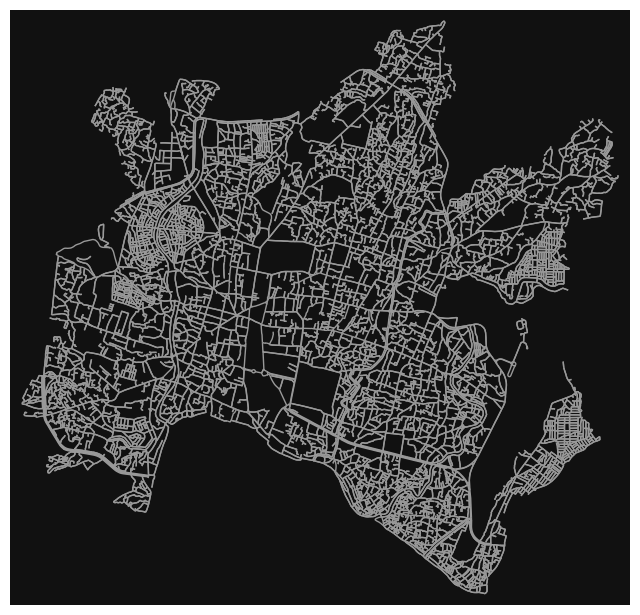

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [59]:
ox.plot_graph(G,node_size=0)

In [60]:
pd.set_option('display.max_columns', None)
nodes, edges = ox.graph_to_gdfs(G)

In [61]:
print(edges['geometry'].values)
print(edges['length'])

<GeometryArray>
[                 <LINESTRING (9502672.849 3213772.958, 9502724.913 3213780.817)>,
 <LINESTRING (9502672.849 3213772.958, 9502614.328 3213775.297, 9502548.605 3...>,
 <LINESTRING (9502672.849 3213772.958, 9502687.832 3213852.811, 9502689.279 3...>,
                  <LINESTRING (9502724.913 3213780.817, 9502672.849 3213772.958)>,
                  <LINESTRING (9502724.913 3213780.817, 9502757.229 3213786.413)>,
 <LINESTRING (9502724.913 3213780.817, 9502718.768 3213772.442, 9502714.649 3...>,
 <LINESTRING (9502462.299 3213794.185, 9502460.206 3213788.714, 9502457.824 3...>,
 <LINESTRING (9502462.299 3213794.185, 9502427.489 3213799.856, 9502424.985 3...>,
 <LINESTRING (9502462.299 3213794.185, 9502490.552 3213788.966, 9502548.605 3...>,
 <LINESTRING (9502727.251 3213894.36, 9502723.477 3213881.319, 9502720.004 32...>,
 ...
                   <LINESTRING (9497372.126 3214850.71, 9497382.568 3214818.402)>,
                  <LINESTRING (9502438.432 3209372.481, 9502466.47

In [62]:
edges.head()

osmid      highway  \
u          v          key                                                   
31019057   2169068697 0                            171603743      primary   
           724349918  0                            171603743      primary   
           5622458522 0    [588729673, 588729674, 588729675]  residential   
2169068697 31019057   0                            171603743      primary   
           360704932  0                            171603743      primary   

                          lanes                      name  ref width  oneway  \
u          v          key                                                      
31019057   2169068697 0       3  चाबहिल-बौद्ध-जोरपाटी सडक  F26    14   False   
           724349918  0       3  चाबहिल-बौद्ध-जोरपाटी सडक  F26    14   False   
           5622458522 0     NaN                       NaN  NaN   NaN   False   
2169068697 31019057   0       3  चाबहिल-बौद्ध-जोरपाटी सडक  F26    14   False   
           360704932  0       3  चाबहिल-बौद्ध-जोरपाटी सडक  F26    14   False   

                          reversed      length  \
u          v          key                        
31019057   2169068697 0       True   46.558692   
           724349918  0      False  187.324116   
           5622458522 0      False  136.056525   
2169068697 31019057   0      False   46.558692   
           360704932  0       True   29.000330   

                                                                    geometry  \
u          v          key                                                      
31019057   2169068697 0    LINESTRING (9502672.849 3213772.958, 9502724.9...   
           724349918  0    LINESTRING (9502672.849 3213772.958, 9502614.3...   
           5622458522 0    LINESTRING (9502672.849 3213772.958, 9502687.8...   
2169068697 31019057   0    LINESTRING (9502724.913 3213780.817, 9502672.8...   
           360704932  0    LINESTRING (9502724.913 3213780.817, 9502757.2...   

                          maxspeed bridge access junction tunnel  
u          v          key                                         
31019057   2169068697 0        NaN    NaN    NaN      NaN    NaN  
           724349918  0        NaN    NaN    NaN      NaN    NaN  
           5622458522 0        NaN    NaN    NaN      NaN    NaN  
2169068697 31019057   0        NaN    NaN    NaN      NaN    NaN  
           360704932  0        NaN    NaN    NaN      NaN    NaN

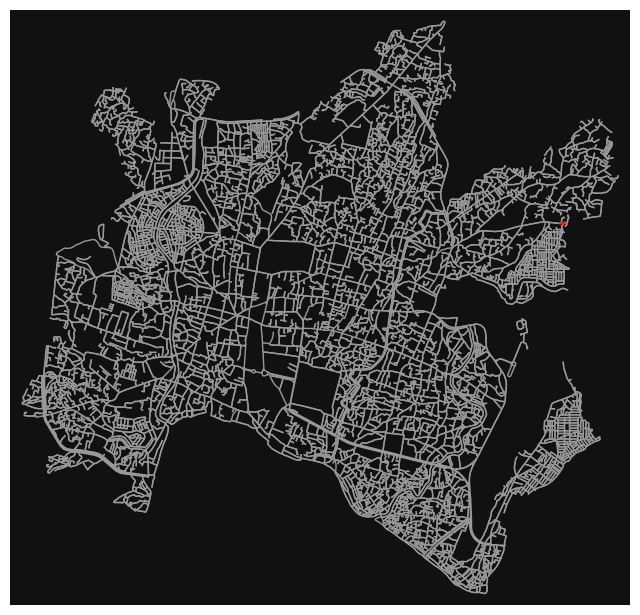

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [64]:
ox.plot.plot_graph_route(G, [31019057,2169068697],node_size=0,route_linewidth=1,orig_dest_size=10)

In [68]:
# Define the origin and destination nodes (choose two random nodes in the graph)
orig = list(G.nodes())[0]
dest = list(G.nodes())[100]

# Apply Dijkstra's algorithm to find the shortest path
# The weight parameter 'length' ensures that we are finding the shortest path by distance
route = nx.dijkstra_path(G, orig, dest, weight='length')

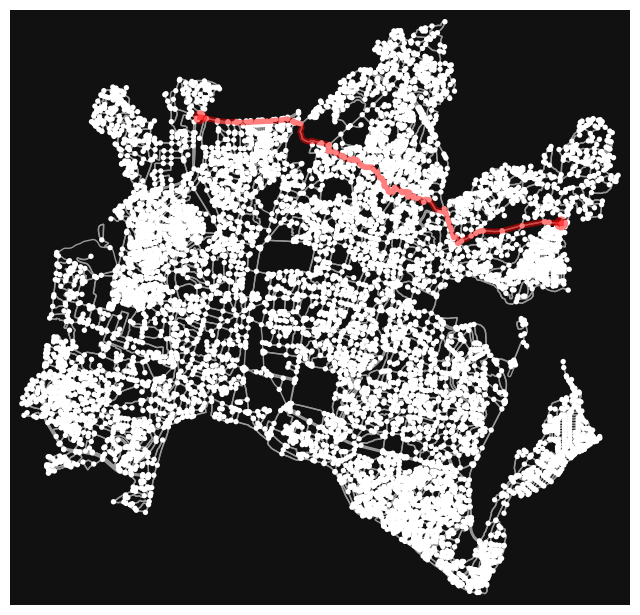

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [69]:
ox.plot_graph_route(G,route=route)